In [1]:
from load_modules import *
from tensorflow.keras.layers import LeakyReLU
import my_config

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    for device in physical_devices:
        print("Device:", device)
else:
    print("No GPU devices found.")

# Set GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, False)
    except RuntimeError as e:
        print(e)

# Test for GPU device name
name = tf.test.gpu_device_name()
if name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(name))

# Print the number of available GPUs
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Found GPU at: /device:GPU:0
Num GPUs Available:  1


Load LUT data and find duplicates, select one of each set where the likeleyhood of the parameter values is the greatest

In [53]:
upper_bounds = [0.99, 0.99, 0.99, 0.99, 0.25]
lower_bounds = [0.01, 0.001, 0.01, 0.6, 0.05]

# Pair up the corresponding bounds and calculate their average
averages = [(u + l) / 2 for u, l in zip(upper_bounds, lower_bounds)]
avg_Cm, avg_Ch, avg_Bm, avg_Bh, avg_T = averages

headers = "Cm,Ch,Bm,Bh,T,sR,sG,sB"
lut_path = r"C:\joel_cpp\FullMonte\FullMonte\lut_rgb.csv"

df = pd.read_csv(lut_path, names=headers.split(","), header=None)
#remove row 0
df = df.iloc[1:]
print(df.head())

#print length of df
print(len(df))
# convert all columns to float
for column in df.columns:
    df[column] = pd.to_numeric(df[column], errors='coerce')

#convert sR, sG, sB to int
rounded_df = df.round({'sR': 0, 'sG': 0, 'sB': 0})
# Step 1: Find duplicate RGB values
duplicates = rounded_df[rounded_df.duplicated(subset=['sR', 'sG', 'sB'], keep=False)].copy() # added .copy()
#print all duplicates
print(duplicates.head())

# Step 2: Calculate the 'likelihood' score for each row
duplicates['likelihood'] = (abs(duplicates['Cm'] - avg_Cm) +
                            abs(duplicates['Ch'] - avg_Ch) +
                            abs(duplicates['Bm'] - avg_Bm) +
                            abs(duplicates['Bh'] - avg_Bh) +
                            abs(duplicates['T'] - avg_T))

# Step 3: Sort by RGB values and likelihood, keeping the row with the lowest likelihood for each RGB group
most_likely_duplicates = duplicates.sort_values(['sR', 'sG', 'sB', 'likelihood']).drop_duplicates(subset=['sR', 'sG', 'sB'])

# Now, most_likely_duplicates should contain your desired rows

# First, remove all duplicates from the original dataframe
df_no_duplicates = df.drop_duplicates(subset=['sR', 'sG', 'sB'], keep=False)

# Concatenate df_no_duplicates with most_likely_duplicates to get the final dataframe
df = pd.concat([df_no_duplicates, most_likely_duplicates])

# If you want to sort it based on index
df.sort_index(inplace=True)
df.head()
#remove duplicates

x = df[['sR', 'sG', 'sB']].to_numpy(dtype='float32')
y = df[['Cm', 'Ch', 'Bm', 'Bh', 'T']].to_numpy(dtype='float32')
#create new csv with headers
# df.to_csv(r'LUTs\large_no_duplicates.csv', index=False, header=True)


#train nn on x,y
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=True)
#remove any header values
x_train = x_train[1:]
x_test = x_test[1:]
y_train = y_train[1:]
y_test = y_test[1:]

#numpy arrays
x_train = np.asarray(x_train).reshape(-1,3).astype('float32')
x_test = np.asarray(x_test).reshape(-1,3).astype('float32')
print(f"length of df {len(df)}")
print(f"bef norm x_train[0] {x_train[0]}")

#normalize
x_train = x_train/255.0
x_test = x_test/255.0
print(f"aft norm x_train[0] {x_train[0]}")

print(f"length of x_train {len(x_train)}")
print(f"length of x_test {len(x_test)}")
print(f"length of y_train {len(y_train)}")
print(f"length of y_test {len(y_test)}")
df.head()
print(f"length of df {len(df)}")
#print random 3 rows
#print unique values of Cm,Ch,Bm,Bh,T
# print(f"unique Cm {df['Cm'].unique()}")
# print(f"unique Ch {df['Ch'].unique()}")
# print(f"unique Bm {df['Bm'].unique()}")
# print(f"unique Bh {df['Bh'].unique()}")
# print(f"unique T {df['T'].unique()}")
#as sorted lists
C_m = sorted(df['Cm'].unique())
C_h = sorted(df['Ch'].unique())
B_m = sorted(df['Bm'].unique())
B_h = sorted(df['Bh'].unique())
T = sorted(df['T'].unique())
print(f"Cm = {C_m}")
print(f"Ch = {C_h}")
print(f"Bm = {B_m}")
print(f"Bh = {B_h}")
print(f"T = {T}")
#min max for each
min_vals = [min(C_m), min(C_h), min(B_m), min(B_h), min(T)]
max_vals = [max(C_m), max(C_h), max(B_m), max(B_h), max(T)]
print(f"upper bounds = {max_vals}")
print(f"lower bounds = {min_vals}")
#integer arrays for sR,sG,sB 0 to 255
# Assuming df is your DataFrame and it has columns 'sR', 'sG', 'sB'
df[['sR', 'sG', 'sB']] = df[['sR', 'sG', 'sB']].astype(float)
df[['sR', 'sG', 'sB']] = df[['sR', 'sG', 'sB']].applymap(np.round)
# Add a 'count' column that counts the number of identical RGB values
df['count'] = df.groupby(['sR', 'sG', 'sB'])['sR'].transform('count')
print(f"number of repeated RGB values {len(df[df['count'] > 1])}")

C:\Users\joeli\AppData\Local\Temp\ipykernel_48000\1374123018.py:11: DtypeWarning: Columns (0,1,2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(lut_path, names=headers.split(","), header=None)


      Cm          Ch Bm Bh          T       sR       sG       sB
1  0.001  0.00760226  0  0       0.01  250.284   202.53  164.882
2  0.001  0.00760226  0  0  0.0614286   251.51  203.617  172.458
3  0.001  0.00760226  0  0  0.0785714  251.799  204.666  173.484
4  0.001  0.00760226  0  0       0.13  252.674  206.214  177.338
5  0.001  0.00760226  0  0   0.164286  253.629  207.254  179.571
749460
      Cm        Ch   Bm   Bh         T     sR     sG     sB
2  0.001  0.007602  0.0  0.0  0.061429  252.0  204.0  172.0
3  0.001  0.007602  0.0  0.0  0.078571  252.0  205.0  173.0
4  0.001  0.007602  0.0  0.0  0.130000  253.0  206.0  177.0
5  0.001  0.007602  0.0  0.0  0.164286  254.0  207.0  180.0
6  0.001  0.007602  0.0  0.0  0.027143  251.0  203.0  168.0
length of df 876607
bef norm x_train[0] [182.601 129.028  78.215]
aft norm x_train[0] [0.71608233 0.5059922  0.30672547]
length of x_train 701284
length of x_test 175321
length of y_train 701284
length of y_test 175321
length of df 876607
Cm =

In [4]:
# upper_bounds = [0.5, 0.32, 0.9, 0.9, 0.25]
# lower_bounds = [0.01, 0.001, 0.2, 0.6, 0.05]

# # Pair up the corresponding bounds and calculate their average
# averages = [(u + l) / 2 for u, l in zip(upper_bounds, lower_bounds)]
# avg_Cm, avg_Ch, avg_Bm, avg_Bh, avg_T = averages

# headers = "Cm,Ch,Bm,Bh,T,sR,sG,sB"

# lut_path = r"c:\joel_cpp\FullMonte\FullMonte\output_test.csv"


# df = pd.read_csv(lut_path, sep=",", header=None, names=headers.split(","))

# # df5 = pd.read_csv(lut_path5, sep=",", header=None, names=headers.split(","))

# #remove row 0
# df = df.iloc[1:]
# print(df.head())

# #print length of df
# print(len(df))
# # convert all columns to float
# for column in df.columns:
#     df[column] = pd.to_numeric(df[column], errors='coerce')

# #convert sR, sG, sB to int
# rounded_df = df.round({'sR': 0, 'sG': 0, 'sB': 0})
# # Step 1: Find duplicate RGB values
# duplicates = rounded_df[rounded_df.duplicated(subset=['sR', 'sG', 'sB'], keep=False)].copy() # added .copy()
# #print all duplicates
# print(duplicates.head())

# # Step 2: Calculate the 'likelihood' score for each row
# # duplicates['likelihood'] = (abs(duplicates['Cm'] - avg_Cm) +
# #                             abs(duplicates['Ch'] - avg_Ch) +
# #                             abs(duplicates['Bm'] - avg_Bm) +
# #                             abs(duplicates['Bh'] - avg_Bh) +
# #                             abs(duplicates['T'] - avg_T))

# # # Step 3: Sort by RGB values and likelihood, keeping the row with the lowest likelihood for each RGB group
# # most_likely_duplicates = duplicates.sort_values(['sR', 'sG', 'sB', 'likelihood']).drop_duplicates(subset=['sR', 'sG', 'sB'])

# # # Now, most_likely_duplicates should contain your desired rows

# # # First, remove all duplicates from the original dataframe
# # df_no_duplicates = df.drop_duplicates(subset=['sR', 'sG', 'sB'], keep=False)

# # # Concatenate df_no_duplicates with most_likely_duplicates to get the final dataframe
# # # df = pd.concat([df_no_duplicates, most_likely_duplicates])

# # # If you want to sort it based on index
# # df.sort_index(inplace=True)
# # df.head()
# # #remove NAN columns
# # df = df.dropna()
# # df.head()
# # df = df[df[['sR', 'sG', 'sB', 'Cm', 'Ch', 'Bm', 'Bh', 'T']].notnull().all(axis=1)]

# x = df[['sR', 'sG', 'sB']].to_numpy(dtype='float32')
# y = df[['Cm', 'Ch', 'Bm', 'Bh', 'T']].to_numpy(dtype='float32')
# #create new csv with headers
# # df.to_csv(r'LUTs\large_no_duplicates.csv', index=False, header=True)


# #train nn on x,y
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=True)
# #remove any header values
# x_train = x_train[1:]
# x_test = x_test[1:]
# y_train = y_train[1:]
# y_test = y_test[1:]

# #numpy arrays
# x_train = np.asarray(x_train).reshape(-1,3).astype('float32')
# x_test = np.asarray(x_test).reshape(-1,3).astype('float32')
# print(f"length of df {len(df)}")
# print(f"bef norm x_train[0] {x_train[0]}")

# #normalize
# x_train = x_train/255.0
# x_test = x_test/255.0
# print(f"aft norm x_train[0] {x_train[0]}")

# print(f"length of x_train {len(x_train)}")
# print(f"length of x_test {len(x_test)}")
# print(f"length of y_train {len(y_train)}")
# print(f"length of y_test {len(y_test)}")
# df.head()
# print(f"length of df {len(df)}")
# #print random 3 rows
# #print unique values of Cm,Ch,Bm,Bh,T
# # print(f"unique Cm {df['Cm'].unique()}")
# # print(f"unique Ch {df['Ch'].unique()}")
# # print(f"unique Bm {df['Bm'].unique()}")
# # print(f"unique Bh {df['Bh'].unique()}")
# # print(f"unique T {df['T'].unique()}")
# #as sorted lists
# C_m = sorted(df['Cm'].unique())
# C_h = sorted(df['Ch'].unique())
# B_m = sorted(df['Bm'].unique())
# B_h = sorted(df['Bh'].unique())
# T = sorted(df['T'].unique())
# print(f"Cm = {C_m}")
# print(f"Ch = {C_h}")
# print(f"Bm = {B_m}")
# print(f"Bh = {B_h}")
# print(f"T = {T}")
# #min max for each
# min_vals = [min(C_m), min(C_h), min(B_m), min(B_h), min(T)]
# max_vals = [max(C_m), max(C_h), max(B_m), max(B_h), max(T)]
# print(f"upper bounds = {max_vals}")
# print(f"lower bounds = {min_vals}")
# #integer arrays for sR,sG,sB 0 to 255
# # Assuming df is your DataFrame and it has columns 'sR', 'sG', 'sB'
# df[['sR', 'sG', 'sB']] = df[['sR', 'sG', 'sB']].astype(float)
# df[['sR', 'sG', 'sB']] = df[['sR', 'sG', 'sB']].applymap(np.round)
# # Add a 'count' column that counts the number of identical RGB values
# df['count'] = df.groupby(['sR', 'sG', 'sB'])['sR'].transform('count')
# print(f"number of repeated RGB values {len(df[df['count'] > 1])}")

In [69]:
np.random.seed(7)
BATCH_SIZE = 4096*16

NUM_NEURONS = 75
NUM_LAYERS = 2
NUM_EPOCHS = 200
LR = 1e-4
MLR = 1e-6
about_string = f"batch_size_{BATCH_SIZE}_neurons_{NUM_NEURONS}_layers_{NUM_LAYERS}_epochs_{NUM_EPOCHS}_lr_{LR}_mlr_{MLR}_upper_bounds_{upper_bounds}_lower_bounds_{lower_bounds}"

def decoder():
    input = Input(shape=(5,), name="decoder_input")
    for i in range(NUM_LAYERS):
        if i == 0:
            x = Dense(NUM_NEURONS, activation='relu', name=f"decoder_dense_{i+1}")(input)
        else:
            x = Dense(NUM_NEURONS, activation='relu', name=f"decoder_dense_{i+1}")(x)
    out = Dense(3, name="encoder_output")(x)
    #leaky relu activation=LeakyReLU(alpha=0.3)
    model = Model(inputs=input, outputs=out, name='decoder')
    return model

def encoder():
    input = Input(shape=(3,),name="encoder_input")
    for i in range(NUM_LAYERS):
        if i == 0:
            x = Dense(NUM_NEURONS, activation='relu', name=f"encoder_dense_{i+1}")(input)
        else:
            x = Dense(NUM_NEURONS, activation='relu', name=f"encoder_dense_{i+1}")(x)
    out = Dense(5, name="decoder_output")(x)
    model = Model(inputs=input, outputs=out, name = 'encoder')
    return model
def autoencoder(encoder, decoder):
    input_end_to_end = Input(shape=(3,))
    l1 = encoder(input_end_to_end)
    l2 = decoder(l1)
    input_list = [encoder.input, decoder.input, input_end_to_end]
    output_list = [encoder.output, decoder.output, l2]
    model = Model(inputs=input_list, outputs=output_list, name = 'autoencoder')
    return model
encoder = encoder()
decoder = decoder()
autoencoder = autoencoder(encoder, decoder)
print(encoder.summary())
print(decoder.summary())
print(autoencoder.summary())

def albedo_loss(y_true, y_pred):
    #l1 norm
    l1_norm = K.sum(K.abs(y_pred - y_true), axis=-1)
    l2_norm = K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))
    # upper_bounds = [1.0, 1.0, 1.0]
    # lower_bounds = [0.0, 0.0, 0.0]
    # upper_bound_mask = tf.math.greater(y_pred, upper_bounds)
    # lower_bound_mask = tf.math.less(y_pred, lower_bounds)
    # out_of_range_mask = tf.logical_or(lower_bound_mask, upper_bound_mask)
    # # Apply a penalty for out of range values)
    # out_of_range_penalty = tf.reduce_sum(tf.cast(out_of_range_mask, tf.float32))/BATCH_SIZE
    return  l1_norm

def parameter_loss(y_true, y_pred):
    #l2 norm
    l2_norm = K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))
    # l1_norm = K.sum(K.abs(y_pred - y_true), axis=-1)
    # lower_bound_mask = tf.math.less(y_pred, lower_bounds)
    # upper_bound_mask = tf.math.greater(y_pred, upper_bounds)
    # out_of_range_mask = tf.logical_or(lower_bound_mask, upper_bound_mask)
    # # Apply a penalty for out of range values)
    # out_of_range_penalty = tf.reduce_sum(tf.cast(out_of_range_mask, tf.float32))/BATCH_SIZE
    return  l2_norm 
    
def end_to_end_loss(y_true, y_pred):
    #l1 norm
    l1_norm = K.sum(K.abs(y_pred - y_true), axis=-1)
    # l2_norm = K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))
    return l1_norm 


# # Compile the autoencoder with the custom loss function and optimizer
# autoencoder.compile(optimizer='adam', loss=[parameter_loss, albedo_loss, end_to_end_loss], loss_weights=[.4,.2, .4])
autoencoder.compile(optimizer='adam', loss=[parameter_loss, albedo_loss, end_to_end_loss], loss_weights=[.3,.1,.6])
# 0.2, 0.1, 0.7
# autoencoder.compile(optimizer='adam', loss=[parameter_loss, albedo_loss, end_to_end_loss], loss_weights=[.1,.1,.8])


Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 3)]               0         
                                                                 
 encoder_dense_1 (Dense)     (None, 75)                300       
                                                                 
 encoder_dense_2 (Dense)     (None, 75)                5700      
                                                                 
 decoder_output (Dense)      (None, 5)                 380       
                                                                 
Total params: 6,380
Trainable params: 6,380
Non-trainable params: 0
_________________________________________________________________
None
Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None

In [70]:
checkpoint = ModelCheckpoint(r"C:\Users\joeli\OneDrive\Documents\GitHub\AutoEncoder_Integrated\autoencoder_best.h5py", monitor='loss', verbose=0,
    save_best_only=True, mode='auto', period=200)
adjust_lr = ReduceLROnPlateau(monitor='loss', factor=0.01, patience=5, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=MLR, lr=LR)
# Define the Keras TensorBoard callback.

logdir=r"C:\Users\joeli\OneDrive\Documents\GitHub\AutoEncoder_Integrated\tensorboard_log_dir"
# tensorboard_callback = tf.keras.callbacks.TensorBoard(filepath=logdir, save_weights_only = True,save_freq = 100,verbose = 1)
print_callback = LambdaCallback(on_epoch_end=lambda epoch, logs: print(f"epoch: {epoch} , {logs}") if epoch % 25 == 0 else None)

callbacks = [
    checkpoint,
    adjust_lr,
    print_callback
]
with tf.device('/device:GPU:0') as device:
    #show device name
    print(device)
    #ae_in: enc_in, dec_in, end_to_end_in
    x = [x_train, y_train,x_train]
     #ae_out: enc_out, dec_out, end_to_end_out
    x_val = [x_test, y_test,x_test]
    #outputs: encoder, decoder, autoencoder
    y = [y_train,x_train,x_train]
    y_val = [y_test,x_test,x_test]
    autoencoder.fit(x,y, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, shuffle=True, validation_data=(x_val, y_val), callbacks=callbacks,verbose=0)

       

None
epoch: 0 , {'loss': 0.8759850859642029, 'decoder_output_loss': 0.8396126627922058, 'encoder_output_loss': 0.8072066903114319, 'decoder_loss': 0.905634343624115, 'val_loss': 0.6658848524093628, 'val_decoder_output_loss': 0.7528085708618164, 'val_encoder_output_loss': 0.6407662630081177, 'val_decoder_loss': 0.6266093254089355, 'lr': 0.001}
epoch: 25 , {'loss': 0.19353675842285156, 'decoder_output_loss': 0.5433456897735596, 'encoder_output_loss': 0.18603020906448364, 'decoder_loss': 0.01988338679075241, 'val_loss': 0.19084633886814117, 'val_decoder_output_loss': 0.5414595603942871, 'val_encoder_output_loss': 0.18259039521217346, 'val_decoder_loss': 0.016915716230869293, 'lr': 0.001}
epoch: 50 , {'loss': 0.17563675343990326, 'decoder_output_loss': 0.5208460092544556, 'encoder_output_loss': 0.124543696641922, 'decoder_loss': 0.011547628790140152, 'val_loss': 0.17522753775119781, 'val_decoder_output_loss': 0.5195483565330505, 'val_encoder_output_loss': 0.12359632551670074, 'val_decoder_

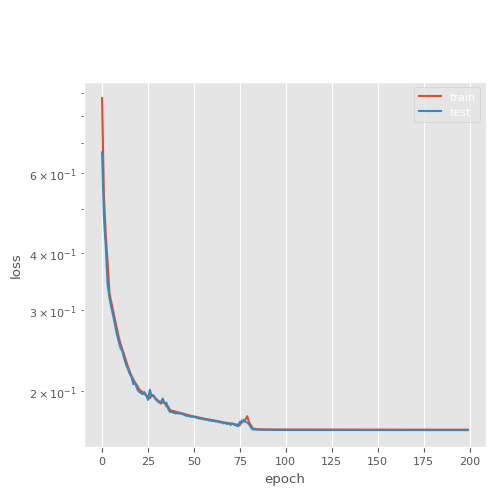

In [71]:
# # Plot the loss function
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
#add tick labels
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
#ggplot style
plt.style.use('ggplot')
plt.figure(figsize=(5,5))
#fontsize 16
plt.rcParams.update({'font.size': 8})
plt.plot(autoencoder.history.history['loss']) 
plt.plot(autoencoder.history.history['val_loss'])
plt.title('model loss \n = encoder loss (L1 norm) + \n decoder loss (L2 norm) +\n end to end loss (L1 norm) ')
plt.ylabel('loss')
plt.yscale('log')
plt.xlabel('epoch')
plt.yticks
# plt.xlim(-1,50)
plt.tight_layout()
plt.legend(['train', 'test'], loc='upper right')
#show tick labels
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.show()




In [72]:
import math
def encode(image):
    print(f"Image shape at start of encoder method: {image.shape}")
    if len(image.shape) == 2:
        WIDTH = HEIGHT = int(math.sqrt(image.shape[0]))
        image = np.asarray(image).reshape(-1,4).astype('float32')
    else:
        WIDTH = image.shape[0]
        HEIGHT = image.shape[1]
        image = np.asarray(image).astype('float32')
    image = image.reshape(WIDTH*HEIGHT, 3) 
    start = time.time()
    with tf.device('/device:GPU:0') as device:
        print(f"Image shape before encoder inference: {image.shape}")
        pred_maps = encoder.predict_on_batch(image)
    #reshape to 1
    end = time.time()
    elapsed = end - start
    #reshape to -1,3
    pred_maps = pred_maps.reshape(WIDTH*HEIGHT, 5)  # for RGB image
    return pred_maps, elapsed, (WIDTH, HEIGHT)
 
def decode(encoded):
    print(f"Image shape going into encoder: {encoded.shape}")
    start = time.time()
    #check if encoded is 2d or 3d
    if len(encoded.shape) == 2:
        WIDTH = HEIGHT = int(math.sqrt(encoded.shape[0]))
        encoded = np.asarray(encoded).reshape(-1,5).astype('float32')
    else:
        WIDTH = encoded.shape[0]
        HEIGHT = encoded.shape[1]
        encoded = np.asarray(encoded).astype('float32')
    with tf.device('/device:GPU:0') as device:
        #lower batch size to 2048
        print(f"encoded shape going into decoder: {encoded.shape}")
        recovered = decoder.predict_on_batch(encoded)
    end = time.time()
    elapsed = end - start
    recovered = recovered.reshape(WIDTH, HEIGHT, 3)  # for RGB image
    return recovered, elapsed, (WIDTH, HEIGHT)

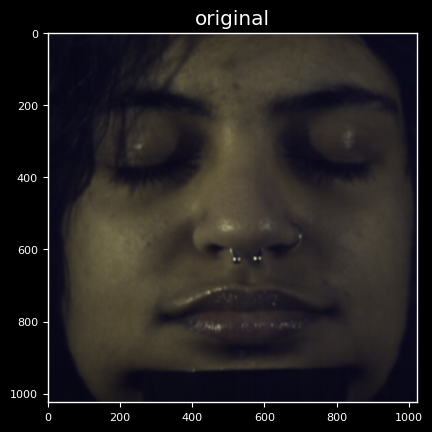

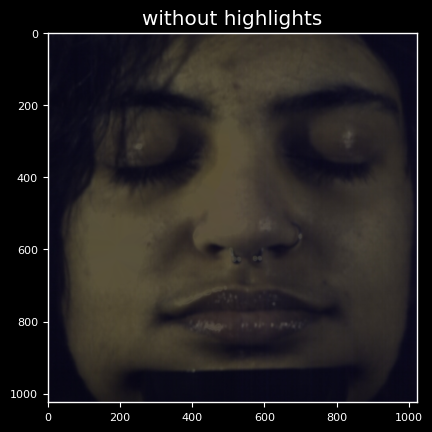

Image shape at start of encoder method: (1024, 1024, 3)
Image shape before encoder inference: (1048576, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


CM 0.0 1.0
CH 0.0 1.0
BM 0.0 1.0
BH 0.0 1.0
T 0.0 1.0
encode time 0.2503666877746582
Image shape going into encoder: (1048576, 5)
encoded shape going into decoder: (1048576, 5)


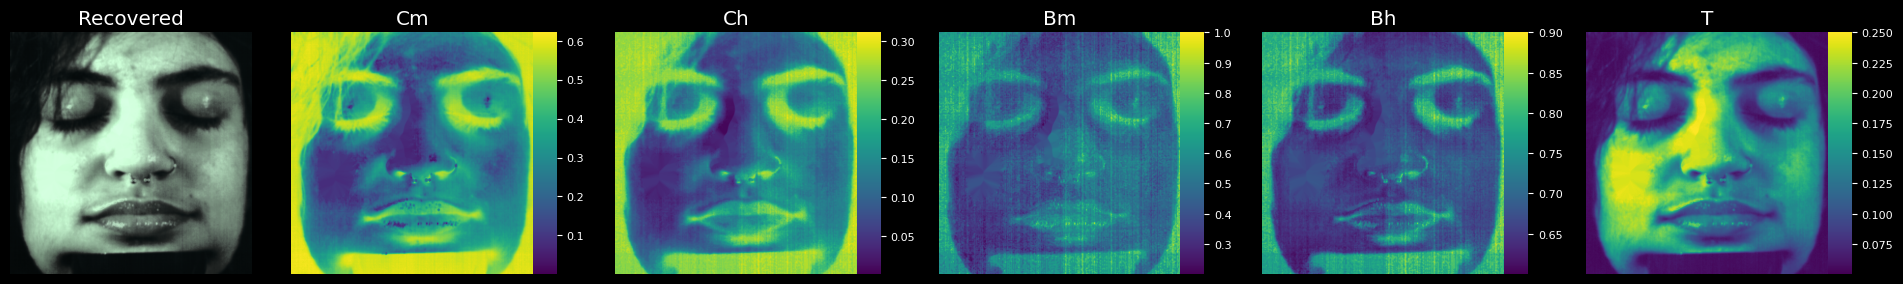

In [74]:
from Landmark import gmm_specular, gmm_shadow, preprocess, plotting
import importlib
import math
WIDTH = 1024
HEIGHT = 1024
#reload
importlib.reload(gmm_specular)
importlib.reload(gmm_shadow)
importlib.reload(preprocess)
importlib.reload(plotting)

#dark background style
plt.style.use('dark_background')
#grid off 
plt.rcParams['axes.grid'] = False
#reload
importlib.reload(gmm_specular)
importlib.reload(gmm_shadow)
# Load your image
image_rgb = cv2.imread( r"C:\Users\joeli\Dropbox\HM_Oct\models_4k\m32.png")
image_rgb = cv2.cvtColor(image_rgb, cv2.COLOR_BGR2RGB)
image_rgb = preprocess.crop_face(image_rgb)[0]
image_rgb = cv2.resize(image_rgb, (WIDTH, HEIGHT))
plt.imshow(image_rgb/255)
plt.title("original")
plt.show()
# Remove specular highlights
image_without_highlights = gmm_specular.remove_specular_highlights(image_rgb)

plt.imshow(image_without_highlights/255)
plt.title("without highlights")
plt.show()


parameter_maps, elapsed, d1 = encode(image_without_highlights)
# parameter_maps, elapsed, d1 = encode(image_rgb)

pm1 = parameter_maps.copy().reshape(d1[0], d1[1], 5)
#normalize
Cm = parameter_maps[:,0]
Ch = parameter_maps[:,1]
Bm = parameter_maps[:,2]
Bh = parameter_maps[:,3]
T = parameter_maps[:,4]
#normalize
Cm = (Cm - np.min(Cm))/(np.max(Cm) - np.min(Cm))
Ch = (Ch - np.min(Ch))/(np.max(Ch) - np.min(Ch))
Bm = (Bm - np.min(Bm))/(np.max(Bm) - np.min(Bm))
Bh = (Bh - np.min(Bh))/(np.max(Bh) - np.min(Bh))
T = (T - np.min(T))/(np.max(T) - np.min(T))
parameter_maps[:,0] = Cm*0.62+0.001
parameter_maps[:,1] = Ch*0.31+0.001
parameter_maps[:,2] = Bm*0.8+0.2
parameter_maps[:,3] = Bh*0.3+0.6
parameter_maps[:,4] = T*0.2+0.05
print(f"CM {Cm.min()} {Cm.max()}")
print(f"CH {Ch.min()} {Ch.max()}")
print(f"BM {Bm.min()} {Bm.max()}")
print(f"BH {Bh.min()} {Bh.max()}")
print(f"T {T.min()} {T.max()}")
WIDTH, HEIGHT = d1
print(f"encode time {elapsed}")

recovered,elapsed, d2 = decode(pm1.reshape(-1,5))
# recovered = cv2.cvtColor(recovered, cv2.COLOR_BGR2RGB)

WIDTH, HEIGHT = d2
recovered = recovered/255

plotting.PLOT_TEX_MAPS(recovered, parameter_maps)

In [10]:
from matplotlib import gridspec
import time
CMAP_SPECULAR = 'viridis'

length = len(images)
rows = length
print(f"length of test images {length}")
columns = 8  # increased to 8 for original, Cm, Ch, Bm, Bh, T, Recovered, deltaE
WIDTH = HEIGHT = DIM = 512
# create a figure with a gridspec of rows x columns
fig = plt.figure(figsize=(2*(columns+1), 2*(rows+1)))
#double the size
widths = np.ones(columns+1)
widths[-1] = 0.1
gs = gridspec.GridSpec(rows, columns+1,
                       wspace=0.0, hspace=0.0,
                       top=1.-0.5/(rows+1), bottom=0.5/(rows+1),
                       left=0.5/(columns+2), right=1-0.5/(columns+2),width_ratios=widths)  # Increase columns by 2
delta_e_strings = []
last_image = None
for i, image in enumerate(images):

    ax0 = fig.add_subplot(gs[i, 0])
    ax0.set_xticks([])
    ax0.set_yticks([])
    ax1 = fig.add_subplot(gs[i, 1])
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax2 = fig.add_subplot(gs[i, 2])
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax3 = fig.add_subplot(gs[i, 3])
    ax3.set_xticks([])
    ax3.set_yticks([])
    ax4 = fig.add_subplot(gs[i, 4])
    ax4.set_xticks([])
    ax4.set_yticks([])
    ax5 = fig.add_subplot(gs[i, 5])
    ax5.set_xticks([])
    ax5.set_yticks([])
    ax6 = fig.add_subplot(gs[i, 6])
    ax6.set_xticks([])
    ax6.set_yticks([])
    ax7 = fig.add_subplot(gs[i, 7])
    ax7.set_xticks([])
    ax7.set_yticks([])
    ax8 = fig.add_subplot(gs[:, 8])
    ax8.set_xticks([])
    ax8.set_yticks([])
    # Set the titles only for the first row
    if i == 0:
        ax0.set_title("Original")
        ax1.set_title("Cm")
        ax2.set_title("Ch")
        ax3.set_title("Bm")
        ax4.set_title("Bh")
        ax5.set_title("T")
        ax6.set_title("Recovered")
        ax7.set_title("deltaE")

    original_img = image

    image = np.asarray(image)
    image_numpy = image.reshape((WIDTH, HEIGHT, 3))
    
    
    pred_maps, encode_time = encode(image)
    print(f"encode time: {encode_time}")

    c_m = np.asarray(pred_maps[:,0])
    c_h = np.asarray(pred_maps[:,1])
    b_m = np.asarray(pred_maps[:,2])
    b_h = np.asarray(pred_maps[:,3])
    t = np.asarray(pred_maps[:,4])
    pred_maps[:,0] = c_m
    pred_maps[:,1] = c_h
    pred_maps[:,2] = b_m 
    pred_maps[:,3] = b_h
    pred_maps[:,4] = t
    recovered, decode_time = decode(pred_maps)
    print(f"decode time: {decode_time}")
    recovered = np.asarray(recovered).reshape((WIDTH, HEIGHT, 3))
    

    c_m = np.asarray(pred_maps[:,0]).reshape(WIDTH, HEIGHT)
    c_h = np.asarray(pred_maps[:,1]).reshape(WIDTH, HEIGHT)
    b_m = np.asarray(pred_maps[:,2]).reshape(WIDTH, HEIGHT)
    b_h = np.asarray(pred_maps[:,3]).reshape(WIDTH, HEIGHT)
    t = np.asarray(pred_maps[:,4]).reshape(WIDTH, HEIGHT)
    #print min,mean,max of each map
    c_m_string = f"c_m: {np.mean(c_m)}, min: {np.min(c_m)}, max: {np.max(c_m)}, std: {np.std(c_m)}"
    c_h_string = f"c_h: {np.mean(c_h)}, min: {np.min(c_h)}, max: {np.max(c_h)}, std: {np.std(c_h)}"
    b_m_string = f"b_m: {np.mean(b_m)}, min: {np.min(b_m)}, max: {np.max(b_m)}, std: {np.std(b_m)}"
    b_h_string = f"b_h: {np.mean(b_h)}, min: {np.min(b_h)}, max: {np.max(b_h)}, std: {np.std(b_h)}"
    t_string = f"t: {np.mean(t)}, min: {np.min(t)}, max: {np.max(t)}, std: {np.std(t)}"
    print(f"cm: {c_m_string}, ch: {c_h_string}, bm: {b_m_string}, bh: {b_h_string}, t: {t_string}")
    
    deltaE = calculate_deltaE(image, recovered).reshape(WIDTH, HEIGHT)
    # recovered = (recovered).astype(np.uint8)
    # recovered = Image.fromarray(recovered)
    delta_e_string = f"deltaE: {np.mean(deltaE)}, min: {np.min(deltaE)}, max: {np.max(deltaE)}, std: {np.std(deltaE)}, encode time: {encode_time}, decode time: {decode_time}, image size: {WIDTH}x{HEIGHT}"
    delta_e_strings.append(delta_e_string)
    print(delta_e_string)
    #set all margins to 0
    # Replace your subplot code with this
    ax1 = fig.add_subplot(gs[i, 0])
    ax1.imshow(image)
    ax1.text(-0.15, .3, f"Model {subject_titles[i]}", fontsize=16, rotation=90, transform=ax1.transAxes)
    ax1.axis('off')
    ax1.set_aspect('equal')
    
    ax2 = fig.add_subplot(gs[i, 1])
    ax2.imshow(c_m, cmap=CMAP_SPECULAR)
    ax2.axis('off')
    ax2.set_aspect('equal')

    ax3 = fig.add_subplot(gs[i, 2])
    ax3.imshow(c_h, cmap=CMAP_SPECULAR)
    ax3.axis('off')
    ax3.set_aspect('equal')

    ax4 = fig.add_subplot(gs[i, 3])
    ax4.imshow(b_m, cmap=CMAP_SPECULAR)
    ax4.axis('off')
    ax4.set_aspect('equal')

    ax5 = fig.add_subplot(gs[i, 4])
    ax5.imshow(b_h, cmap=CMAP_SPECULAR)
    ax5.axis('off')
    ax5.set_aspect('equal')

    ax6 = fig.add_subplot(gs[i, 5])
    ax6.imshow(t, cmap=CMAP_SPECULAR)
    ax6.axis('off')
    ax6.set_aspect('equal')

    ax7 = fig.add_subplot(gs[i, 6])
    ax7.imshow(recovered)
    ax7.axis('off')
    ax7.set_aspect('equal')


    ax8 = fig.add_subplot(gs[i, 7])
    last_image = ax8.imshow(deltaE, cmap=CMAP_SPECULAR, vmin=0, vmax=20)
    ax8.axis('off')
    ax8.set_aspect('equal')
if i == rows-1:
    cbar_ax = fig.add_subplot(gs[:, -1])
    last_image = ax8.imshow(deltaE, cmap=CMAP_SPECULAR, vmin=0, vmax=20)
    fig.colorbar(last_image, cax=cbar_ax, pad=0.01)
    cbar_ax.yaxis.set_label_position('right')
    cbar_ax.set_xticks([])

#ask for user input to save the figure
# save = input("Save figure? (y/n): ")
# if save == "y":
#     result_path = my_config.LOCAL_SAVE
#     directory_name = input("Enter directory name: ")
#     path = os.path.join(result_path, directory_name)
#     if not os.path.exists(path):
#         plt.savefig(path, dpi=500, bbox_inches='tight')
#     plt.subplots_adjust(wspace=0, hspace=0)
#     plt.show()

NameError: name 'images' is not defined

In [ ]:
directory_path =  my_config.LOCAL_SAVE 
#ask user for folder name
folder_name = input("Enter folder name: ")
directory_path = os.path.join(directory_path, folder_name)
if not os.path.exists(directory_path):
    os.makedirs(directory_path)
# Saving the models as .pb files
# tf.saved_model.save(encoder, os.path.join(directory_path, 'encoder_pb'))
# tf.saved_model.save(decoder, os.path.join(directory_path, 'decoder_pb'))
# tf.saved_model.save(autoencoder, os.path.join(directory_path, 'autoencoder_pb'))
# Saving the models as .h5 files
encoder_path = directory_path + 'encoder.h5'
decoder_path = directory_path + 'decoder.h5'
autoencoder_path = directory_path + 'ae.h5'
encoder.save(encoder_path)
decoder.save(decoder_path)
autoencoder.save(autoencoder_path)


In [ ]:
# Ensure your model is in inference mode
encoder.trainable = False
decoder.trainable = False
input_shape_encoder = (None, 3)
input_shape_decoder = (None, 5)
# Alternatively, use the following to convert a model to inference mode
# encoder_model = tf.keras.models.clone_model(encoder, clone_function=lambda layer: layer if "dropout" not in layer.get_config().get("name", "").lower() else tf.keras.layers.Activation("linear")(layer.output))
# decoder_model = tf.keras.models.clone_model(decoder, clone_function=lambda layer: layer if "dropout" not in layer.get_config().get("name", "").lower() else tf.keras.layers.Activation("linear")(layer.output))
# Define the input signature
input_signature_encoder = [tf.TensorSpec(shape=[None, *input_shape_encoder], dtype=tf.float32)]
input_signature_decoder = [tf.TensorSpec(shape=[None, *input_shape_decoder], dtype=tf.float32)]

# Convert model call to a tf.function with the defined input signature
# encoder_func = tf.function(encoder_model.call).get_concrete_function(input_signature_encoder)
# decoder_func = tf.function(decoder_model.call).get_concrete_function(input_signature_decoder)

# Save the models with the specific signatures
tf.saved_model.save(encoder, "encoder_sep_19")
tf.saved_model.save(decoder, "decoder_sep_19")

INFO:tensorflow:Assets written to: encoder_sep_19\assets
INFO:tensorflow:Assets written to: decoder_sep_19\assets


encode time: 2.658036947250366


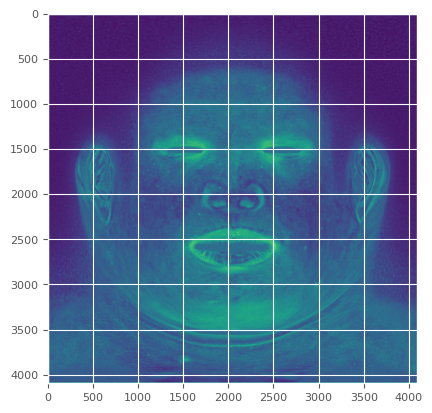

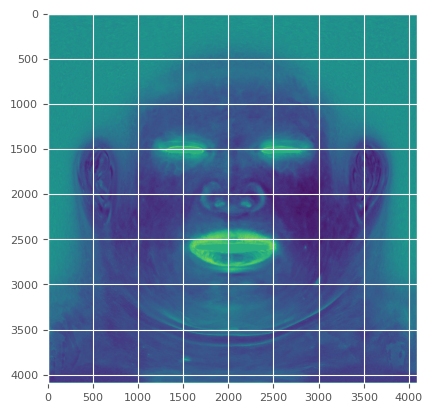

decode time: 3.3481345176696777


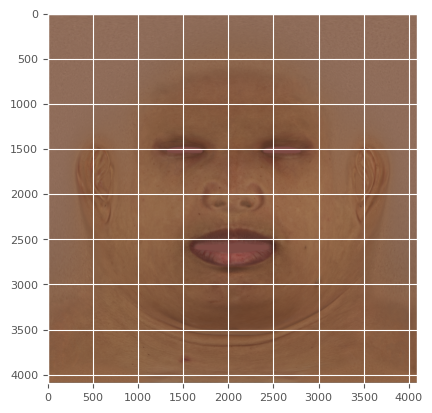

In [ ]:
import numpy as np
import onnxruntime as ort
import time
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf

# Load the ONNX models
encoder_session = ort.InferenceSession(r"C:\Users\joeli\Dropbox\Code\AE_2023_06\encoder_sep_7.onnx")
decoder_session = ort.InferenceSession(r"C:\Users\joeli\Dropbox\Code\AE_2023_06\decoder_sep_7.onnx")
image_path = "C:\\Users\\joeli\\Dropbox\\AE_MC\\AE_InputModels\\m46.png"
WIDTH = 4096
HEIGHT = 4096
image = Image.open(image_path).resize((WIDTH, HEIGHT)).convert('RGB')

def encode_onnx(img):
    image = np.asarray(img).reshape(-1,3).astype('float32')/255.0
    start = time.time()

    # Run the ONNX model
    with tf.device('/device:GPU:0') as device:
        pred_maps = encoder_session.run(None, {'encoder_input': image})[0]

    end = time.time()
    elapsed = end - start
    return pred_maps, elapsed

def decode_onnx(encoded):
    start = time.time()

    # Run the ONNX model
    with tf.device('/device:GPU:0') as device:
        recovered = decoder_session.run(None, {'decoder_input': encoded})[0]
    end = time.time()
    elapsed = end - start
    return recovered, elapsed

pred_maps, encode_time = encode_onnx(image)
print(f"encode time: {encode_time}")


Cm = pred_maps[:,0].reshape(WIDTH, HEIGHT)
Ch = pred_maps[:,1].reshape(WIDTH, HEIGHT)
Bm = pred_maps[:,2].reshape(WIDTH, HEIGHT)
Bh = pred_maps[:,3].reshape(WIDTH, HEIGHT)
T = pred_maps[:,4].reshape(WIDTH, HEIGHT)
plt.imshow(Cm)
plt.show()
plt.imshow(Ch)
plt.show()
#normalize

recovered, decode_time = decode_onnx(pred_maps)
print(f"decode time: {decode_time}")
plt.imshow(recovered.reshape(WIDTH, HEIGHT, 3))
plt.show()

In [ ]:
# encoder.save('keras_model.keras')
# decoder_path = r"C:\Users\joeli\Dropbox\Code\AE_2023_06\decoder_sep_7"
# encoder_path = r"C:\Users\joeli\Dropbox\Code\AE_2023_06\encoder_sep_7"
# decoder = tf.keras.models.load_model(decoder_path)
# encoder = tf.keras.models.load_model(encoder_path)
encoder = load_model(my_config.ENCODER_PATH)
decoder = load_model(my_config.DECODER_PATH)

image_path = "C:\\Users\\joeli\\Dropbox\\AE_MC\\AE_InputModels\\m46.png"
WIDTH = 1024
HEIGHT = 1024
image = Image.open(image_path).resize((WIDTH, HEIGHT)).convert('RGB')
def encode(img):
    image = np.asarray(img).reshape(-1,3).astype('float32')
    # pred_maps = encoder.predict(image)
    start = time.time()
    with tf.device('/device:GPU:0') as device:
        pred_maps = encoder.predict_on_batch(image)
    end = time.time()
    elapsed = end - start
    return pred_maps, elapsed
 
def decode(encoded):
    # recovered = decoder.predict(encoded)
    start = time.time()
    with tf.device('/device:GPU:0') as device:
        #lower batch size to 2048
        recovered = decoder.predict_on_batch(encoded)
        # recovered = decoder.predict_on_batch(encoded)
    end = time.time()
    elapsed = end - start
    recovered = np.clip(recovered, 0, 1)
    
    return recovered, elapsed

![Alt text](image.png)

In [ ]:
# sRGB = np.array([146.14,81.28,69.13])/255
sRGB = np.array([0.27, 0.766, 0.754])
sRGB.reshape(3,1)
w1 = encoder.layers[1].get_weights()[0]
b1 = encoder.layers[1].get_weights()[1]
w2 = encoder.layers[2].get_weights()[0]
b2 = encoder.layers[2].get_weights()[1]
w3 = encoder.layers[3].get_weights()[0]
b3 = encoder.layers[3].get_weights()[1]
w4 = decoder.layers[1].get_weights()[0]
b4 = decoder.layers[1].get_weights()[1]
w5 = decoder.layers[2].get_weights()[0]
b5 = decoder.layers[2].get_weights()[1]
w6 = decoder.layers[3].get_weights()[0]
b6 = decoder.layers[3].get_weights()[1]
#encoder
z1 = np.matmul(w1.T, sRGB) + b1
a1 = np.maximum(0, z1)
z2 = np.matmul(w2.T, a1) + b2
a2 = np.maximum(0, z2)
z3 = np.matmul(w3.T, a2) + b3
a3 = np.maximum(0, z3)
#decoder
z4 = np.matmul(w4.T, a3) + b4
a4 = np.maximum(0, z4)
z5 = np.matmul(w5.T, a4) + b5
a5 = np.maximum(0, z5)
z6 = np.matmul(w6.T, a5) + b6
a6 = np.maximum(0, z6)

def graph_encode(sRGB):
    z1 = np.matmul(w1.T, sRGB) + b1
    a1 = np.maximum(0, z1)
    z2 = np.matmul(w2.T, a1) + b2
    a2 = np.maximum(0, z2)
    z3 = np.matmul(w3.T, a2) + b3
    a3 = np.maximum(0, z3)
    return a3
def graph_decode(encoded):
    z4 = np.matmul(w4.T, encoded) + b4
    a4 = np.maximum(0, z4)
    z5 = np.matmul(w5.T, a4) + b5
    a5 = np.maximum(0, z5)
    z6 = np.matmul(w6.T, a5) + b6
    a6 = np.maximum(0, z6)
    return a6

print(f"RGB Shape: {sRGB.shape}")
print(f"sRGB: {sRGB}")
print(f"w1 shape {w1.shape}")
print(f"w2 shape {w2.shape}")
print(f"w3 shape {w3.shape}")
print(f"w4 shape {w4.shape}")
print(f"w5 shape {w5.shape}")
print(f"w6 shape {w6.shape}")
print(f"b1 shape {b1.shape}")
print(f"b2 shape {b2.shape}")
print(f"b3 shape {b3.shape}")
print(f"b4 shape {b4.shape}")
print(f"b5 shape {b5.shape}")
print(f"b6 shape {b6.shape}")
print(f"z1 shape {z1.shape}")
print(f"a1 shape {a1.shape}")
print(f"z2 shape {z2.shape}")
print(f"a2 shape {a2.shape}")
print(f"z3 shape {z3.shape}")
print(f"a3 shape {a3.shape}")
print(f"z4 shape {z4.shape}")
print(f"a4 shape {a4.shape}")
print(f"z5 shape {z5.shape}")
print(f"a5 shape {a5.shape}")
print(f"z6 shape {z6.shape}")
print(f"a6 shape {a6.shape}")
encoder_prediction = encoder.predict(sRGB.reshape(1,3))
print(f"Computation Graph Encoding: {a3}")
print(f"Encoding Prediction {encoder_prediction}")
decoder_prediction = decoder.predict(encoder_prediction)
print(f"Computation Graph Decoding: {a6}")
print(f"Decoding Prdiction {decoder_prediction}")
# Save weights and biases to a  csv file
# np.savetxt("w1.csv", w1, delimiter=",")
# np.savetxt("w2.csv", w2, delimiter=",")
# np.savetxt("w3.csv", w3, delimiter=",")
# np.savetxt("b1.csv", b1, delimiter=",")
# np.savetxt("b2.csv", b2, delimiter=",")
# np.savetxt("b3.csv", b3, delimiter=",")
# np.savetxt("w4.csv", w4, delimiter=",")
# np.savetxt("w5.csv", w5, delimiter=",")
# np.savetxt("w6.csv", w6, delimiter=",")
# np.savetxt("b4.csv", b4, delimiter=",")
# np.savetxt("b5.csv", b5, delimiter=",")
# np.savetxt("b6.csv", b6, delimiter=",")
# Load weights and biases from a binary file

RGB Shape: (3,)
sRGB: [0.27  0.766 0.754]
w1 shape (3, 75)
w2 shape (75, 75)
w3 shape (75, 5)
w4 shape (5, 75)
w5 shape (75, 75)
w6 shape (75, 3)
b1 shape (75,)
b2 shape (75,)
b3 shape (5,)
b4 shape (75,)
b5 shape (75,)
b6 shape (3,)
z1 shape (75,)
a1 shape (75,)
z2 shape (75,)
a2 shape (75,)
z3 shape (5,)
a3 shape (5,)
z4 shape (75,)
a4 shape (75,)
z5 shape (75,)
a5 shape (75,)
z6 shape (3,)
a6 shape (3,)
1/1 [==============================] - 0s 27ms/step
Computation Graph Encoding: [0.         1.12675227 0.9621538  0.6790808  0.37708729]
Encoding Prediction [[-0.04083298  1.1267523   0.96215373  0.67908084  0.3770873 ]]
1/1 [==============================] - 0s 26ms/step
Computation Graph Decoding: [0.71492559 0.6400595  0.64378515]
Decoding Prdiction [[0.83602667 0.7446222  0.86423093]]


image shape: (256, 256, 3)


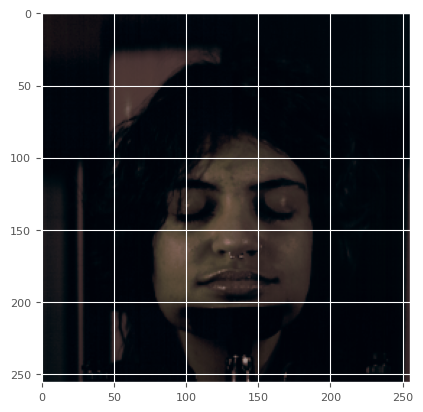

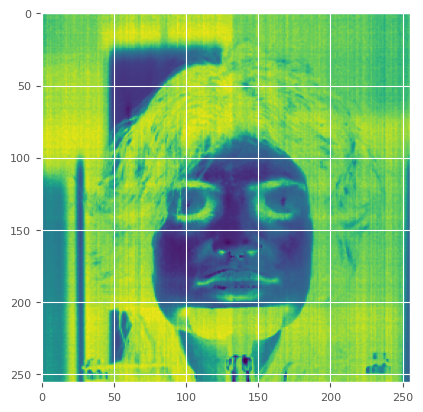

In [ ]:
image_path = r"D:\HSI_DATASET\train_vis\RGB_CIE\p006_neutral_front.jpg"
plt.show()
WIDTH = 256
HEIGHT = 256
image = Image.open(image_path).resize((WIDTH, HEIGHT)).convert('RGB')
image = np.asarray(image).astype('float32')/255.0
recovered = np.zeros((WIDTH, HEIGHT, 3))
parameter_maps = np.zeros((WIDTH, HEIGHT, 5))
print(f"image shape: {image.shape}")
for row in range(image.shape[0]):
    for col in range(image.shape[1]):
        rgb = image[row][col]
        rgb = rgb.reshape(3,)
        #encoder
        params = graph_encode(rgb)
        #decoder
        recovered_rgb = graph_decode(params)
        recovered[row][col] = recovered_rgb.reshape(3)
        parameter_maps[row][col] = params.reshape(5)

plt.imshow(recovered)
plt.show()
plt.imshow(parameter_maps[:,:,0])
plt.show()


In [ ]:
image_path = r"D:\HSI_DATASET\train_vis\RGB_CIE\p006_neutral_front.jpg"
image = Image.open(image_path).resize((WIDTH, HEIGHT)).convert('RGB')
image = np.asarray(image).astype('float32')/255.0
encoded = encoder.predict(image.reshape(1,256,256,3)).reshape(256,256,5)
decoded = decoder.predict(encoded)
fig, ax = plt.subplots(1,6)
for channel in encoded

SyntaxError: invalid syntax (1490934086.py, line 7)

In [ ]:
from PIL import Image
w1 = encoder.layers[1].get_weights()[0]
b1 = encoder.layers[1].get_weights()[1]
w2 = encoder.layers[2].get_weights()[0]
b2 = encoder.layers[2].get_weights()[1]
w3 = encoder.layers[3].get_weights()[0]
b3 = encoder.layers[3].get_weights()[1]
w4 = decoder.layers[1].get_weights()[0]
b4 = decoder.layers[1].get_weights()[1]
w5 = decoder.layers[2].get_weights()[0]
b5 = decoder.layers[2].get_weights()[1]
w6 = decoder.layers[3].get_weights()[0]
b6 = decoder.layers[3].get_weights()[1]

def graph_encode(sRGB):
    z1 = np.matmul(w1.T, sRGB) + b1
    a1 = np.maximum(0, z1)
    z2 = np.matmul(w2.T, a1) + b2
    a2 = np.maximum(0, z2)
    z3 = np.matmul(w3.T, a2) + b3
    a3 = np.maximum(0, z3)
    return a3
def graph_decode(encoded):
    z4 = np.matmul(w4.T, encoded) + b4
    a4 = np.maximum(0, z4)
    z5 = np.matmul(w5.T, a4) + b5
    a5 = np.maximum(0, z5)
    z6 = np.matmul(w6.T, a5) + b6
    a6 = np.maximum(0, z6)
    return a6
def extract_unique_rgb(image_path):
    # Open the image and convert to RGB
    image = Image.open(image_path).convert('RGB')
    # Get all the pixels from the image
    pixels = list(image.getdata())
    # Use a set to find unique RGB values
    unique_rgb = set(pixels)
    # Convert back to a list
    unique_rgb_list = list(unique_rgb)
    return unique_rgb_list

image_path = "C:\\Users\\joeli\\Dropbox\\AE_MC\\AE_InputModels\\m46.png"
WIDTH = 256
HEIGHT = 256
image = Image.open(image_path).resize((WIDTH, HEIGHT)).convert('RGB')

unique_values = extract_unique_rgb(image_path)
# print(unique_values)
print(len(unique_values))
#print total number of pixels
# print(f"number of total pixels: {WIDTH*HEIGHT}")
percent = len(unique_values)/(WIDTH*HEIGHT)
print(f"percent of unique values: {percent*100}%")
image_np = np.asarray(image).astype('int32')

rgb_param = {}  # dictionary to store encoded values
param_recovered = {}  # dictionary to store decoded values

for rgb in unique_values:
    # print(f"rgb {rgb}")  # Print RGB value being processed
    
    encoded_val = graph_encode(np.asarray(rgb)/255.0)
    # print(f"encoded value {encoded_val}")
    cm_mask = np.ones_like(encoded_val)
    cm_mask[0] = 2.5
    cm_mask[1] = 2.0

    encoded_val = encoded_val * cm_mask
    rgb_param[rgb] = encoded_val
    param_recovered[rgb] = graph_decode(encoded_val)
    # print(f"encoded value {encoded_val}")
    # print(f"decoded value {param_recovered[rgb]}")


# Display the original image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns
ax1.imshow(image)
ax1.set_title('Original Image')
ax1.axis('off')

# Initialize the right plot with the original image
recovered = np.copy(image_np)
img_plot = ax2.imshow(recovered)
ax2.set_title('Recovered Image')
ax2.axis('off')

plt.tight_layout()
plt.ion()  # Turn on interactive mode

index = 0
for rgb, encoded_value in rgb_param.items():
    mask = np.all(image_np == np.array(rgb), axis=-1)
    recovered_rgb = param_recovered[rgb]
    
    recovered[mask] = recovered_rgb
    parameter_maps[mask] = encoded_value
    
    if index % 1000 == 0:  # Update the image every 1000 unique RGB values for better performance
        img_plot.set_data(recovered)  # Update the recovered image data
        plt.pause(0.2)  # Introduce a slight delay to visualize the update
        print(f"percent complete: {index/len(unique_values)*100}%")
    index += 1

plt.ioff()  # Turn off the interactive mode
plt.show()

# Show the parameter map for the first parameter
plt.imshow(parameter_maps[:, :, 0], cmap='viridis')
plt.title('Parameter Map 0')
plt.colorbar()
plt.show()

19083
percent of unique values: 29.11834716796875%


KeyboardInterrupt: 

In [ ]:
for nm in range(380,790,10):
    print(f"nm: {nm}")

nm: 380
nm: 390
nm: 400
nm: 410
nm: 420
nm: 430
nm: 440
nm: 450
nm: 460
nm: 470
nm: 480
nm: 490
nm: 500
nm: 510
nm: 520
nm: 530
nm: 540
nm: 550
nm: 560
nm: 570
nm: 580
nm: 590
nm: 600
nm: 610
nm: 620
nm: 630
nm: 640
nm: 650
nm: 660
nm: 670
nm: 680
nm: 690
nm: 700
nm: 710
nm: 720
nm: 730
nm: 740
nm: 750
nm: 760
nm: 770
nm: 780
